<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_1C2024_GRUPO02_N2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


<font color='#fa5050'>Importante: para correr este notebook es pre-requisito haber corrido el notebook numero 1, ya que de lo contrario no se tienen los datasets de train y test.</font>

# Importación de librerias

In [100]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Lectura de archivo

### Desde google drive

In [101]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02"

train_file = drive_path + '/Dataset/ds_train.csv'
test_file = drive_path + '/Dataset/ds_test.csv'

ds_train = pd.read_csv(train_file)
ds_test = pd.read_csv(test_file)
using_drive = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Desde maquina local

In [102]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# train_file = './dataset/ds_train.csv'
# test_file = './dataset/ds_test.csv'

# ds_train = pd.read_csv(train_file)
# ds_test = pd.read_csv(test_file)
# using_drive = False

# Agrupamiento

Analizaremos la tendencia al agrupamiento del dataset y la cantidad optima de grupos.

## Tendencia al clustering
Analizar la tendencia al clustering del dataset.

In [103]:
ds_train.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,...,property_surface_covered,property_price,z_property_bedrooms,zm_property_bedrooms,place_encoded,type_encoded,score_property_surface,score_price_surface_total,score_location_price,property_location_surface_covered
0,Ab/aN6T8Mna0dAIe9hPIpA==,2021-04-10,2021-06-05,2021-04-10,-34.558977,-58.458816,Belgrano,Departamento,3.0,2.0,...,71.0,152000.0,0.111655,0.111655,7,7,-1.000000e+09,-1.160892,-0.981818,-1.000000
1,MzDpszQ1Zx3SGERGycYoSw==,2021-03-05,2021-03-09,2021-03-05,-34.551437,-58.454158,Nuñez,Departamento,2.0,1.0,...,38.0,116000.0,-0.896360,-0.896360,25,25,-1.000000e+00,-1.412184,-1.016862,-1.000000
2,Axqbmsbzc9JHXG5S0xW0fg==,2021-03-10,2021-05-06,2021-03-10,-34.638146,-58.509707,Villa Luro,Departamento,3.0,2.0,...,54.0,82000.0,0.111655,0.111655,50,50,-1.000000e+00,-1.335574,-1.001649,-1.000000
3,ds5G1c/HVhlxBxwWAGvn3Q==,2021-03-29,2021-04-15,2021-03-29,-34.585703,-58.418339,Palermo,Departamento,4.0,3.0,...,100.0,260000.0,1.119670,1.119670,27,27,-1.000000e+00,-1.028576,-1.000000,-1.000000
4,DuRHdE5YZY2gPv3gNbtB3Q==,2021-10-23,2021-11-03,2021-10-23,-34.568861,-58.505879,Villa Urquiza,PH,5.0,4.0,...,137.0,235000.0,2.127685,2.127685,57,57,-1.085423e+00,-1.630562,-1.000000,-1.057145


Para agrupar, podemos dejar de lado la columna 'place_l3', ya que podemos completar los datos necesarios para realizar el clustering utilizando las columnas de latitud y longitud. Además, podemos eliminar la columna 'id', ya que generalmente solo sirve como un identificador único para cada fila y no es una característica relevante para el clustering. Similarmente, podemos descartar cualquier información relacionada con fechas, ya que no es necesaria para nuestro análisis de clustering.

In [104]:
ds_cluster_train = ds_train.copy()
ds_cluster_test = ds_test.copy()

columnas_a_eliminar = ['place_l3','id','start_date','end_date','created_on']
ds_cluster_train.drop(columns = columnas_a_eliminar,inplace=True)
ds_cluster_test.drop(columns = columnas_a_eliminar,inplace=True)

In [105]:
ds_cluster_train.head()

,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_property_bedrooms,zm_property_bedrooms,place_encoded,type_encoded,score_property_surface,score_price_surface_total,score_location_price,property_location_surface_covered
0,-34.558977,-58.458816,Departamento,3.0,2.0,78.0,71.0,152000.0,0.111655,0.111655,7,7,-1.000000e+09,-1.160892,-0.981818,-1.000000
1,-34.551437,-58.454158,Departamento,2.0,1.0,38.0,38.0,116000.0,-0.896360,-0.896360,25,25,-1.000000e+00,-1.412184,-1.016862,-1.000000
2,-34.638146,-58.509707,Departamento,3.0,2.0,54.0,54.0,82000.0,0.111655,0.111655,50,50,-1.000000e+00,-1.335574,-1.001649,-1.000000
3,-34.585703,-58.418339,Departamento,4.0,3.0,138.0,100.0,260000.0,1.119670,1.119670,27,27,-1.000000e+00,-1.028576,-1.000000,-1.000000
4,-34.568861,-58.505879,PH,5.0,4.0,273.0,137.0,235000.0,2.127685,2.127685,57,57,-1.085423e+00,-1.630562,-1.000000,-1.057145


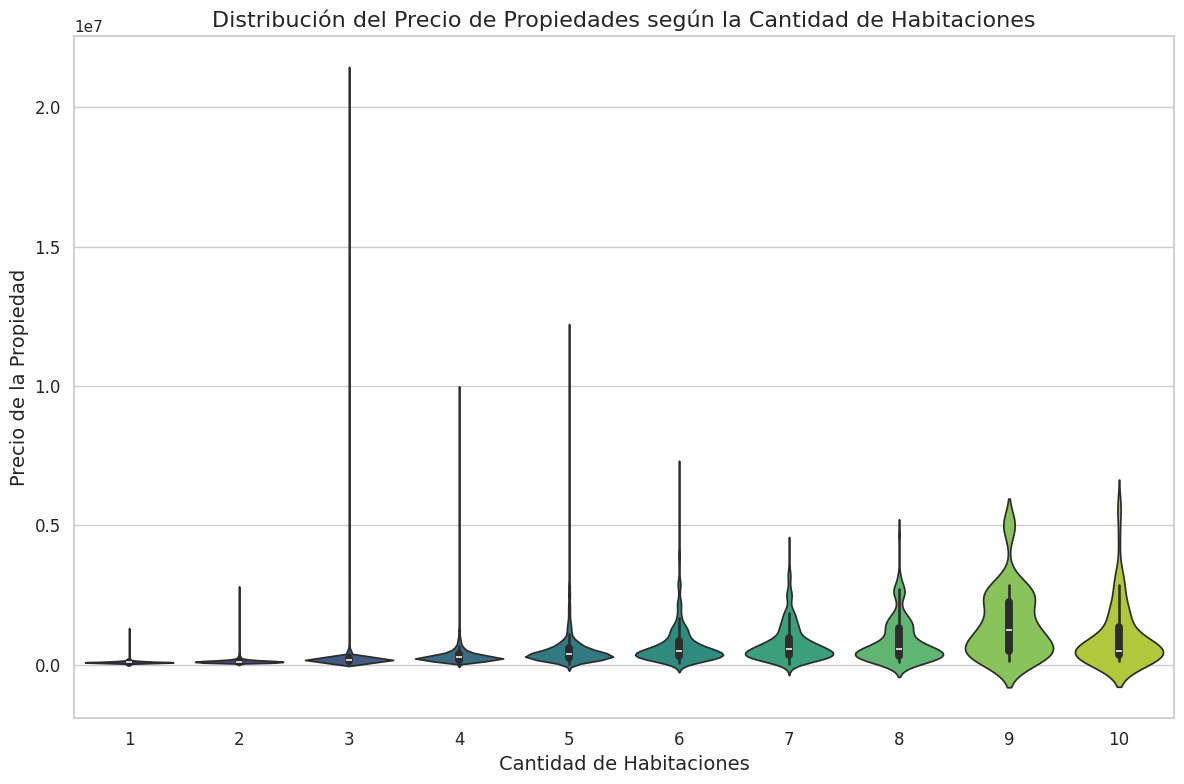

In [106]:
# Redondear la variable property_rooms
ds_with_rounded_rooms = ds_cluster_train.copy()
ds_with_rounded_rooms['property_rooms'] = np.round(ds_with_rounded_rooms['property_rooms']).astype(int)

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear el Violin Plot con paleta de colores "viridis"
sns.violinplot(data=ds_with_rounded_rooms, x='property_rooms', y='property_price', palette='viridis')

# Añadir título y etiquetas con tamaño de fuente ajustado
plt.title('Distribución del Precio de Propiedades según la Cantidad de Habitaciones', fontsize=16)
plt.xlabel('Cantidad de Habitaciones', fontsize=14)
plt.ylabel('Precio de la Propiedad', fontsize=14)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustar espaciado
plt.tight_layout()

# Mostrar el gráfico
plt.show()

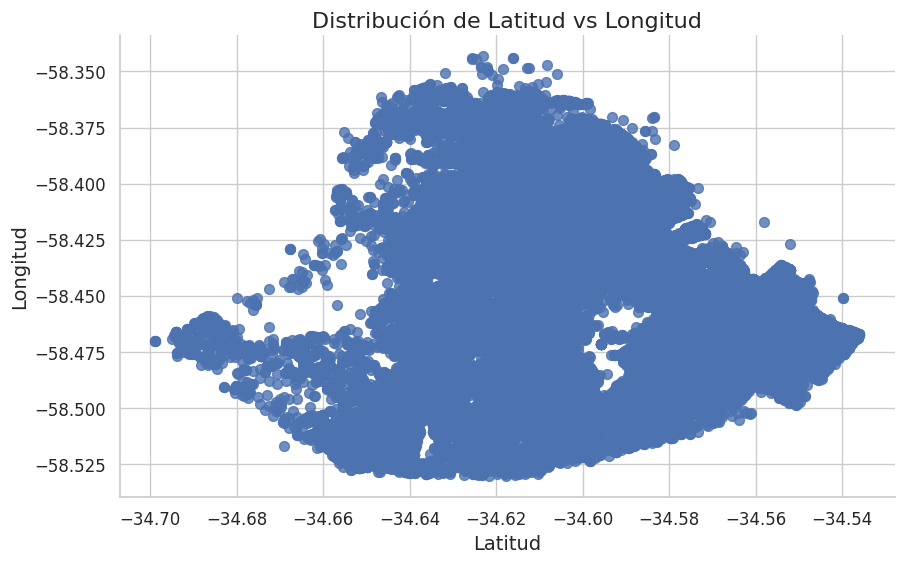

In [107]:
# @title latitud vs longitud

# Configuración de la figura y los ejes
plt.figure(figsize=(10, 6))

# Creación del gráfico de dispersión
plt.scatter(ds_cluster_train['latitud'], ds_cluster_train['longitud'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Distribución de Latitud vs Longitud", fontsize=16)
plt.xlabel("Latitud", fontsize=14)
plt.ylabel("Longitud", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [108]:
ds_cluster_test.head()

,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,-34.639975,-58.438678,Departamento,2.0,1.0,48.0,42.0,95000.0
1,-34.603768,-58.433634,Departamento,3.0,2.0,73.0,73.0,137000.0
2,-34.625908,-58.417775,Departamento,4.0,3.0,79.0,71.0,138900.0
3,-34.612766,-58.496000,Departamento,2.0,1.0,42.0,42.0,92900.0
4,-34.615833,-58.371799,Departamento,4.0,3.0,97.0,72.0,129900.0


Vamos a realizar una transformación de variables para trabajar con todos datos numéricos. En este caso, vamos a utilizar la regresión logística para la variable proterty_type

In [109]:
ds_cluster_train = pd.get_dummies(ds_cluster_train, columns=["property_type"])
ds_cluster_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_property_bedrooms,zm_property_bedrooms,place_encoded,type_encoded,score_property_surface,score_price_surface_total,score_location_price,property_location_surface_covered,property_type_Casa,property_type_Departamento,property_type_PH
0,-34.558977,-58.458816,3.0,2.0,78.0,71.0,152000.0,0.111655,0.111655,7,7,-1.000000e+09,-1.160892,-0.981818,-1.000000,False,True,False
1,-34.551437,-58.454158,2.0,1.0,38.0,38.0,116000.0,-0.896360,-0.896360,25,25,-1.000000e+00,-1.412184,-1.016862,-1.000000,False,True,False
2,-34.638146,-58.509707,3.0,2.0,54.0,54.0,82000.0,0.111655,0.111655,50,50,-1.000000e+00,-1.335574,-1.001649,-1.000000,False,True,False
3,-34.585703,-58.418339,4.0,3.0,138.0,100.0,260000.0,1.119670,1.119670,27,27,-1.000000e+00,-1.028576,-1.000000,-1.000000,False,True,False
4,-34.568861,-58.505879,5.0,4.0,273.0,137.0,235000.0,2.127685,2.127685,57,57,-1.085423e+00,-1.630562,-1.000000,-1.057145,False,False,True


In [110]:
ds_cluster_test = pd.get_dummies(ds_cluster_test, columns=["property_type"])
ds_cluster_test.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Casa,property_type_Departamento,property_type_PH
0,-34.639975,-58.438678,2.0,1.0,48.0,42.0,95000.0,False,True,False
1,-34.603768,-58.433634,3.0,2.0,73.0,73.0,137000.0,False,True,False
2,-34.625908,-58.417775,4.0,3.0,79.0,71.0,138900.0,False,True,False
3,-34.612766,-58.496000,2.0,1.0,42.0,42.0,92900.0,False,True,False
4,-34.615833,-58.371799,4.0,3.0,97.0,72.0,129900.0,False,True,False


Aplico máximos y minimos para normalizar el dataset. De esta manera los valores seleccionados estaran escalados entre 0 y 1 acordemente.

In [111]:
def aplicar_max_min(ds, columnas):
    scaler = MinMaxScaler()
    for columna in columnas:
        ds[[columna]] = scaler.fit_transform(ds[[columna]])

columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered', 'property_price']

aplicar_max_min(ds_cluster_train,columnas_con_numeros)

In [112]:
ds_cluster_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_property_bedrooms,zm_property_bedrooms,place_encoded,type_encoded,score_property_surface,score_price_surface_total,score_location_price,property_location_surface_covered,property_type_Casa,property_type_Departamento,property_type_PH
0,-34.558977,-58.458816,0.222222,0.166667,0.025995,0.029889,0.006871,0.111655,0.111655,7,7,-1.000000e+09,-1.160892,-0.981818,-1.000000,False,True,False
1,-34.551437,-58.454158,0.111111,0.000000,0.011136,0.014453,0.005188,-0.896360,-0.896360,25,25,-1.000000e+00,-1.412184,-1.016862,-1.000000,False,True,False
2,-34.638146,-58.509707,0.222222,0.166667,0.017080,0.021937,0.003599,0.111655,0.111655,50,50,-1.000000e+00,-1.335574,-1.001649,-1.000000,False,True,False
3,-34.585703,-58.418339,0.333333,0.333333,0.048283,0.043454,0.011919,1.119670,1.119670,27,27,-1.000000e+00,-1.028576,-1.000000,-1.000000,False,True,False
4,-34.568861,-58.505879,0.444444,0.500000,0.098432,0.060761,0.010750,2.127685,2.127685,57,57,-1.085423e+00,-1.630562,-1.000000,-1.057145,False,False,True


## Cantidad de grupos a formar

Para estimar la cantidad de grupos que se deberian formar vamos a utilizar la Regla del codo (Elbow Method).

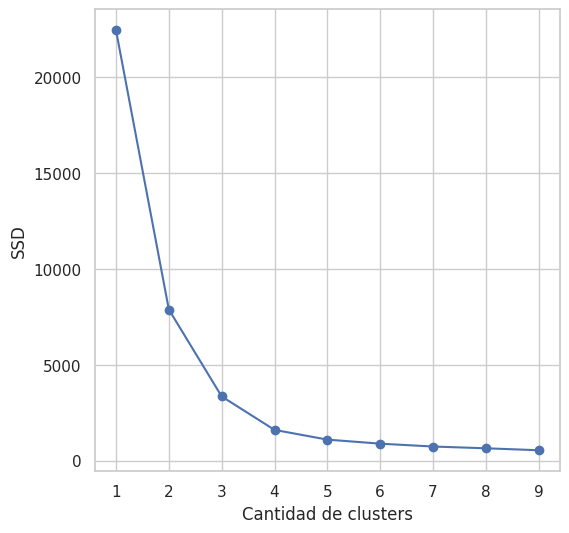

In [113]:
to_remove = ['z_property_bedrooms', 'zm_property_bedrooms', 'place_encoded', 'type_encoded', 'score_property_surface', 'score_price_surface_total', 'score_location_price', 'property_location_surface_covered']
ds_cluster_train.drop(columns=to_remove, inplace=True)
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
ssd = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(ds_cluster_train)
    ssd.append(km.inertia_)

# Grafico el SSD por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, ssd, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSD')

# Si se quiere desactivar la notación científica en el eje y
# plt.ticklabel_format(style='plain', axis='y')

plt.show()

Al ver el gráfico no tenemos un codo pronunciadamente, pero sabemos que la cantidad optima de grupos esta entre 2 y 5. Entonces verificamos la cantidad de conjuntos a elegir con el método de Silhouette.

### Analisis de calidad de grupos con Silhouette
Evaluar la calidad de los grupos formados realizando un análisis de Silhouette.

Para esto se utilizaran entre 2 y 5 grupos siguiendo lo que observamos en el anterior grafico.

In [114]:
# Se define una lista de números de clusters a probar
list_k = list(range(2, 6))

# Se itera sobre cada número de clusters
for n_clusters in list_k:
    # Se inicializa el modelo de KMeans con el número de clusters actual
    clusterer = KMeans(n_clusters=n_clusters)

    # Se ajusta el modelo a los datos de entrenamiento y se realizan predicciones sobre los clusters
    preds = clusterer.fit_predict(ds_cluster_train)

    # Se calcula el coeficiente de Silhouette para evaluar la calidad de los clusters
    score = silhouette_score(ds_cluster_train, preds)

    # Se imprime el coeficiente de Silhouette para el número actual de clusters
    print("\n\nFor n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))




For n_clusters =2 silhouette score is 0.7818118953678767


For n_clusters =3 silhouette score is 0.828706863616286


For n_clusters =4 silhouette score is 0.6195158527748484


For n_clusters =5 silhouette score is 0.6338411727665123


Un coeficiente de Silhouette cercano a 1 indica que los clusters están bien definidos y son densos, con una separación clara entre ellos. Por lo tanto, un coeficiente de Silhouette de 0.9994413130556185 es muy alto y sugiere que el número óptimo de clusters es 2, ya que proporciona una buena separación entre los puntos de datos dentro de los clusters y una buena distancia entre los clusters.

### Analisis de distribucion de los grupos

Ahora veremos si estos grupos obtenidos estan balanceados.

In [115]:
balance_analisis_ds = ds_cluster_train.copy()

In [116]:
def print_clusters_info(clusters_ds, min_clusters, max_clusters):
    for i in range(min_clusters, max_clusters+1):
        two_groups = KMeans(n_clusters=i)
        two_groups.fit(clusters_ds)
        y_two_groups = two_groups.predict(clusters_ds)

        clusters_ds['Cluster'] = y_two_groups
        print(f"{i} Clusters:\n", clusters_ds["Cluster"].value_counts(), "\n")

In [117]:
print_clusters_info(balance_analisis_ds, 2, 5)

2 Clusters:
 Cluster
1    61778
0    10483
Name: count, dtype: int64 

3 Clusters:
 Cluster
0    61778
1     7365
2     3118
Name: count, dtype: int64 

4 Clusters:
 Cluster
0    30900
3    30878
1     7365
2     3118
Name: count, dtype: int64 

5 Clusters:
 Cluster
1    30878
0    18141
4    12759
2     7365
3     3118
Name: count, dtype: int64 



In [118]:
balance_analisis_ds.keys()

Index(['latitud', 'longitud', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price',
       'property_type_Casa', 'property_type_Departamento', 'property_type_PH',
       'Cluster'],
      dtype='object')

In [119]:
# remove columns
to_remove = ['Cluster']
filtered_clusters_ds = balance_analisis_ds.drop(columns=to_remove)
print_clusters_info(filtered_clusters_ds, 2, 5)

2 Clusters:
 Cluster
1    61778
0    10483
Name: count, dtype: int64 

3 Clusters:
 Cluster
1    61778
2     7365
0     3118
Name: count, dtype: int64 

4 Clusters:
 Cluster
0    30900
3    30878
1     7365
2     3118
Name: count, dtype: int64 

5 Clusters:
 Cluster
0    30878
1    18129
3    12771
2     7365
4     3118
Name: count, dtype: int64 



## Análisis de grupos <font color='#fa5050'>(En progreso)</font>
Realizar un análisis de cada grupo intentando entender en función de qué características
fueron formados.

## Clusters en el mapa de CABA <font color='#fa5050'>(En progreso)</font>

In [120]:
# Coordenadas del centro de la Ciudad Autónoma de Buenos Aires
latitud = -34.6037
longitud = -58.3816

# Crear el mapa centrado en Buenos Aires
mapa = folium.Map(location=[latitud, longitud], zoom_start=12)

ds_latitud_longitud = ds_cluster_train[['latitud','longitud']]
ds_latitud_longitud.shape

(72261, 2)

In [121]:
# OJO QUE ACÁ ESTOY DISMINUYENDO LA CANTIDAD DE PROPIEDADES

ds_latitud_longitud = ds_latitud_longitud.sample(n=1000)

# Iterar sobre las filas del DataFrame ds_latitud_longitud
for index, row in ds_latitud_longitud.iterrows():
    # Obtener las coordenadas de cada punto
    punto_latitud = row['latitud']
    punto_longitud = row['longitud']

    # Añadir un marcador para cada punto
    folium.Marker(location=[punto_latitud, punto_longitud]).add_to(mapa)

# Mostrar el mapa
mapa

In [122]:
mapa_cluster = folium.Map(location=[latitud, longitud], zoom_start=12)

marcador = MarkerCluster()

for index, row in ds_latitud_longitud.iterrows():
    # Obtener las coordenadas de cada punto
    punto_latitud = row['latitud']
    punto_longitud = row['longitud']

    # Añadir un marcador para cada punto
    marcador.add_child(folium.Marker(location=[punto_latitud, punto_longitud]))

mapa_cluster.add_child(marcador)


## Análisis con tres grupos <font color='#fa5050'>(En progreso)</font>
Repetir el análisis anterior, utilizando sólo 3 grupos.